# 目标检测数据集

这里我们来一步一步复现李沐代码中的识别🍌章节的代码

In [1]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from utils.bbox import *
from utils.show import *

数据集自己手动从这里下载：http://d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip
放到哪就写进下面的`data_dir`中。

In [2]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = "./data/banana-detection"
    # print(data_dir)
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))

    # tmp_targets = torch.tensor(targets).unsqueeze(1) / 256
    # print(tmp_targets.shape)
    return images, torch.tensor(targets).unsqueeze(1) / 256

> 要使用torch中的dataset，必须要实现__getitem__和__len__方法，如下

In [3]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [4]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

In [5]:
batch_size =  32
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

torch.Size([1000, 1, 5])
read 1000 training examples
torch.Size([100, 1, 5])
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

In [12]:
batch[1][0]

tensor([[0.0000, 0.0430, 0.7227, 0.2695, 0.9297]])

从上面的数据`batch[0].shape, batch[1].shape`其实就可以看出这个架构，对于`load_data_bananas(batch_size)`，我们会read两次，一次是read 所有的training examples，另一次是read 所有的validation examples，然后这里没有shuffle，然后再分别batch，但上面可以看到我们其实只是拿了一小部分的train数据来用（32个），然后对于这个拿出来的batch，我们从结构上可以看d2l里的解释如下：

- batch[0]：图像的小批量的形状为（批量大小、通道数、高度、宽度），看起来很眼熟：它与我们之前图像分类任务中的相同。
- batch[1]：标签的小批量的形状为（批量大小，$m$，5），其中$m$是数据集的任何图像中边界框可能出现的最大数量。

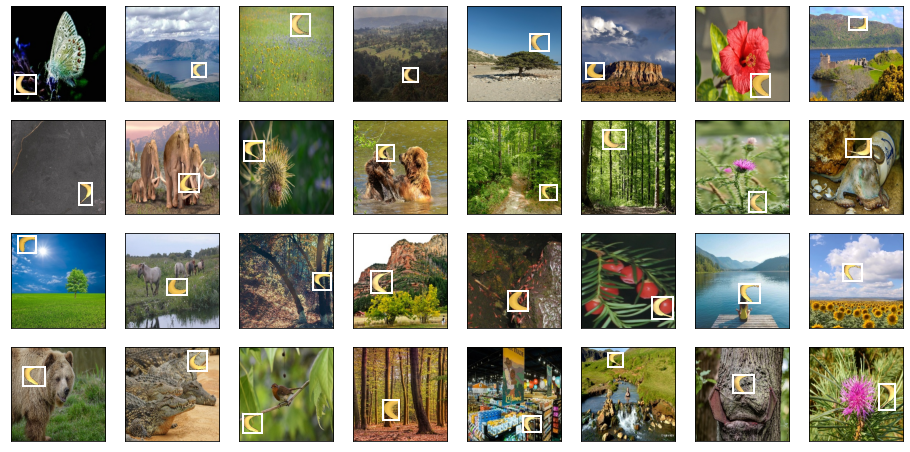

In [6]:
edge_size = 256 # 这个是因为labels中的坐标是相对于256*256的图像的，换言之就是被压缩到了0-1之间
img_num = 32
rows = 4
cols = img_num // rows
# 图像的尺寸为(批量大小, 1, 256, 256) -> (批量大小, 256, 256, 1)。
imgs = (batch[0][0:img_num].permute(0, 2, 3, 1)) / 255
# 画出图像
axes = show_images(imgs, rows, cols, scale=2)
# 在图像上画出标签框
for ax, label in zip(axes, batch[1][0:img_num]):
    show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])